# Sentiment analysis

source: https://www.kaggle.com/ngyptr/python-nltk-sentiment-analysis

## Import Libraries and Data

### Import Libraries

In [0]:
import numpy as np
import pandas as pd
import nltk
from nltk.corpus import stopwords
import re

In [0]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.cross_validation import KFold
from sklearn.metrics import accuracy_score


/usr/local/lib/python3.6/dist-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [0]:
#import dataset SUBTASK A

!pip install -U -q PyDrive
import os
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# choose a local (colab) directory to store the data.
local_download_path = os.path.expanduser('~/data')
try:
  os.makedirs(local_download_path)
except: pass

# 2. Auto-iterate using the query syntax
# https://developers.google.com/drive/v2/web/search-parameters
file_list = drive.ListFile(
    {'q': "'1Aktr0IFuIZeUq95gmB-l1df4hNfcXD5-' in parents"}).GetList()

for f in file_list:
  # 3. Create & download by id.
  print('title: %s, id: %s' % (f['title'], f['id']))
  fname = os.path.join(local_download_path, f['title'])
  print('downloading to {}'.format(fname))
  f_ = drive.CreateFile({'id': f['id']})
  f_.GetContentFile(fname)

title: 2016-test.csv, id: 17kfrME8OQKJpJEHOvPmfiLpbydSx6pYk
downloading to /root/data/2016-test.csv
title: 2016-train.csv, id: 1mRZo0ID_7-xjCSzhKau8dzTL-xHVEkqj
downloading to /root/data/2016-train.csv
title: twitter-2016test-A.txt, id: 1Cb_hfSdjd8AQuONUhXGgogAfc5xEYZsN
downloading to /root/data/twitter-2016test-A.txt
title: twitter-2016train-A.txt, id: 1FQMs5-29fL53IBNgrzQeTtCTMpTtQl_G
downloading to /root/data/twitter-2016train-A.txt
title: twitter-2015test-A.txt, id: 1PbofkglgtOFB3cjle4Y0GweBKU46Y1jr
downloading to /root/data/twitter-2015test-A.txt
title: twitter-2014test-A.txt, id: 1RvjYO-D7e5akDuFzRCX0lvr43QUOjwz8
downloading to /root/data/twitter-2014test-A.txt
title: twitter-2016devtest-A.txt, id: 1NYvycz9Z5r_iUXWtS4G1krR71glFmhbx
downloading to /root/data/twitter-2016devtest-A.txt
title: twitter-2013train-A.txt, id: 1HYlsk9Fg33Mf6C7LXuQ-PqASvgMZ6oFC
downloading to /root/data/twitter-2013train-A.txt
title: twitter-2014sarcasm-A.txt, id: 10W7EBp7vj01qeRXH6RYhigawt9AaL4ly
download

In [0]:
nltk.download('stopwords')
stopword = stopwords.words("english")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Reading the Data

Langkah pertama adalah meng-import data training dan testing task A tahun 2016, dan menggabungkan kedua data tersebut untuk kemudian di-split sebelum proses training

In [0]:
# import data
data1 = pd.read_csv('/root/data/2016-train.csv', header=None, \
                   names=['ID', 'sentiment', 'text'])
data2 = pd.read_csv('/root/data/2016-test.csv', header=None, \
                        names=['ID', 'sentiment', 'text', 'timestamp'])

data = data1.append(data2, ignore_index=True)

In [0]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26500 entries, 0 to 26499
Data columns (total 4 columns):
ID           26500 non-null object
sentiment    26500 non-null object
text         26500 non-null object
timestamp    10 non-null object
dtypes: object(4)
memory usage: 828.2+ KB


In [0]:
data['sentiment'].value_counts()

neutral     12343
positive    10076
negative     4080
[;              1
Name: sentiment, dtype: int64

In [0]:
data.head()

,ID,sentiment,text,timestamp
0,628949369883000000,negative,dear @Microsoft the newOoffice for Mac is grea...,NaN
1,628976607420645000,negative,@Microsoft how about you make a system that do...,NaN
2,629023169169518000,negative,I may be ignorant on this issue but... should ...,NaN
3,629179223232479000,negative,"Thanks to @microsoft, I just may be switching ...",NaN
4,629186282179153000,neutral,If I make a game as a #windows10 Universal App...,NaN


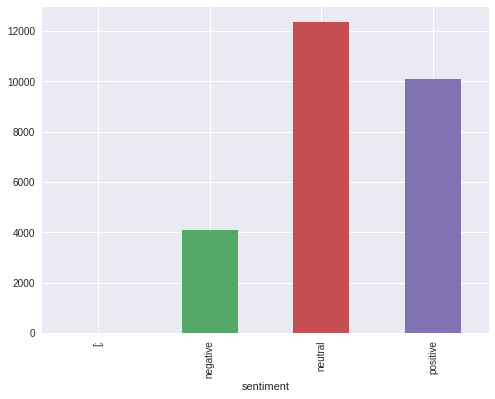

In [0]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(8,6))
data.groupby('sentiment').text.count().plot.bar()
plt.show()

Data ini berisi berisi 26500 tweet beserta sentiment-nya dalam bentuk neutral, positive, negative, dan satu buah data dengan kategori '[;'. Data ini kemudian akan di-drop karena memiliki *sentiment* yang dianggap tidak diketahui.

Dataset ini memiliki 3 buah atribut, berupa ID, sentiment, text, dan timestamp. Untuk kepentingan *sentiment analysis*, maka atribut yang akan digunakan adalah **text** dan **sentiment**.

## Data preprocessing

In [0]:
# drop rows with unrelated sentiment
data = data[data['sentiment'].isin(['neutral', 'positive', 'negative'])]
data['sentiment'].value_counts()

neutral     12343
positive    10076
negative     4080
Name: sentiment, dtype: int64

In [0]:
# Keeping only neccessary columns
data = data[['text', 'sentiment']]

#change sentiments
data['sentiment'] = data['sentiment'].map({"negative": 0, "neutral":1, "positive": 2})

In [0]:
def clean_text(data):
  clean = []

  for index, row in data.iterrows():
      words = re.sub("[^a-zA-Z]", " ", row.text)
      words_lowered = [e.lower() for e in words.split() if len(e) >= 3]
      words_stripped = [word for word in words_lowered
          if 'http' not in word
          and not word.startswith('@')
          and not word.startswith('#')
          and not word.startswith('&')
          and not word.isdigit()
          and word != 'RT']
      words_filtered = [word for word in words_stripped if not word in stopword]
      clean.append([" ".join(words_filtered).strip(), row.sentiment])
  return clean

In [0]:
data.head(10)

,text,sentiment
0,dear @Microsoft the newOoffice for Mac is grea...,0
1,@Microsoft how about you make a system that do...,0
2,I may be ignorant on this issue but... should ...,0
3,"Thanks to @microsoft, I just may be switching ...",0
4,If I make a game as a #windows10 Universal App...,1
5,"Microsoft, I may not prefer your gaming branch...",2
6,@MikeWolf1980 @Microsoft I will be downgrading...,0
7,@Microsoft 2nd computer with same error!!! #Wi...,0
8,Just ordered my 1st ever tablet; @Microsoft Su...,2
9,"After attempting a reinstall, it still bricks,...",0


Membersihkan text dari kata-kata yang tidak diperlukan, seperti

1.   Mention (@)
2.   Hashtag (#)
1.   Link
1.   Angka atau simbol-simbol yang tidak diperlukan
2.   'RT'


In [0]:
cleaned = pd.DataFrame(clean_text(data), columns=['text', 'sentiment'])
cleaned.head()

,text,sentiment
0,dear microsoft newooffice mac great lync updat...,0
1,microsoft make system eat friggin discs time h...,0
2,may ignorant issue celebrate microsoft parenta...,0
3,thanks microsoft may switching apple,0
4,make game windows universal app xboxone owners...,1


## Data Exploration

In [0]:
positive = cleaned[cleaned['sentiment'].isin(['2'])]
positive = positive['text']
negative = cleaned[cleaned['sentiment'].isin(['0'])]
negative = negative['text']
neutral = cleaned[cleaned['sentiment'].isin(['1'])]
neutral = neutral['text']


In [0]:
vectorizer = CountVectorizer()
vector = vectorizer.fit_transform(data['text'])
print("Number of features:  %d" % len(vectorizer.vocabulary_))
print("\n")

sum_words = vector.sum(axis=0) 
words_freq = [(word, sum_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
most_freq = words_freq[:10]
for word, freq in most_freq:
  print(word, freq)

Number of features:  43949


the 21740
to 11910
co 8607
in 7790
and 7637
on 7250
of 6531
is 6016
for 5656
it 5463


#### POSITIVE

In [0]:
pos_vector = vectorizer.fit_transform(positive)
print("Number of features with POSITIVE sentiment:  %d" % len(vectorizer.vocabulary_))
print("------------------")

sum_words = pos_vector.sum(axis=0) 
words_freq = [(word, sum_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
most_freq = words_freq[:10]
for word, freq in most_freq:
  print(word, freq)

Number of features with POSITIVE sentiment:  20350
------------------
tomorrow 1942
may 1443
day 1298
see 939
friday 777
night 754
going 703
amp 675
time 605
sunday 589


#### Neutral

In [0]:
neu_vector = vectorizer.fit_transform(neutral)
print("Number of features with POSITIVE sentiment:  %d" % len(vectorizer.vocabulary_))
print("------------------")

sum_words = neu_vector.sum(axis=0) 
words_freq = [(word, sum_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
most_freq = words_freq[:10]
for word, freq in most_freq:
  print(word, freq)

Number of features with POSITIVE sentiment:  26539
------------------
may 2164
tomorrow 1520
amp 739
sunday 719
friday 691
day 671
going 666
like 664
night 650
time 599


#### Negative

In [0]:
neg_vector = vectorizer.fit_transform(negative)
print("Number of features with POSITIVE sentiment:  %d" % len(vectorizer.vocabulary_))
print("------------------")

sum_words = neg_vector.sum(axis=0) 
words_freq = [(word, sum_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
most_freq = words_freq[:10]
for word, freq in most_freq:
  print(word, freq)

Number of features with POSITIVE sentiment:  11639
------------------
may 1090
tomorrow 385
like 355
amp 253
day 246
going 199
time 194
friday 191
get 189
one 188


## Split Data

Membagi data menjadi train dan test

In [0]:
from sklearn.model_selection import train_test_split
text = cleaned['text']
label = cleaned['sentiment']
train_text, test_text, train_label, test_label = train_test_split(text, label, \
                                                                  test_size=0.25, \
                                                                  random_state=777)

In [0]:
test_label.value_counts()

1    3044
2    2565
0    1016
Name: sentiment, dtype: int64

In [0]:
train_label.value_counts()

1    9299
2    7511
0    3064
Name: sentiment, dtype: int64

In [0]:
test_label = test_label.reset_index(drop=True)

## Feature Selection

### naive bayes

In [0]:
from sklearn.naive_bayes import MultinomialNB

vect = CountVectorizer(max_features=30000)
train_vector = vect.fit_transform(train_text)
test_vector = vect.transform(test_text)

clf = MultinomialNB()

clf.fit(train_vector, train_label)
prediction = clf.predict(test_vector)
accuracy = accuracy_score(test_label, prediction)
print ('Accuracy:', accuracy)

Accuracy: 0.6161509433962264


In [0]:
neg = 0
neu = 0
pos = 0
row = 0

for pred in prediction:
  if pred == test_label[row]:
    if pred == 0:
      neg = neg + 1
    elif pred == 1:
      neu = neu + 1
    elif pred == 2:
      pos = pos + 1
  row = row + 1
    
print("True prediction percentage:")
print("---------------------------")
print("Positive: ", (pos/test_label[test_label == 2].count()))
print("Neutral: ", (neu/test_label[test_label == 1].count()))
print("Negative: ", (neg/test_label[test_label == 0].count()))

True prediction percentage:
---------------------------
Positive:  0.6955165692007798
Neutral:  0.6557161629434954
Negative:  0.297244094488189


#### Prediksi yang dihasilkan bias terhadap data dengan label positif atau netral karena terjadinya ketidakseimbangan data dengan label negatif, dan classifier yang dihasilkan GaussianNB menggunakan probabilitas terhadap data train sehingga tidak dapat menghasilkan prediksi yang baik apabila data train yang dimiliki tidak seimbang antar label yang tersedia.